# Class 6: Bayesian Methods

In this class we will review Bayesian likelihood methods for solving statistical problems, determining the posterior probabilities of model parameters, and selecting between two models.  At the end of these activities you should be able to:

- Understand the application of Bayes' theorem in model-fitting and the role of priors
- Obtain parameter values and confidence ranges via likelihood methods
- Search parameter space with MCMC algorithms
- Apply model selection using the Bayes factor or Akaike information criteria

## Bayesian methods

Bayesian statistics is a framework that allows us to **assign probabilities to a model**.  It makes use of conditional probabilities $P(A|B)$, meaning "the probability of $A$ on the condition that $B$ has occurred".

An important role in Bayesian statistics is played by **Bayes' theorem**, which can be derived from elementary probability:

$P(A|B) = \frac{P(B|A) \, P(A)}{P(B)}$

Bayes' theorem can be re-written for science in the form:

$P(model|data) = \frac{P(data|model) \, P(model)}{P(data)}$

- $P(model|data)$ is the **posterior** probability of the model in light of the data
- $P(data|model)$ is the **likelihood** function of the data given the model
- $P(model)$ is the **prior** probability of the model
- $P(data)$ is the **evidence**, which can typically be absorbed into the normalization of the posterior

### The likelihood

For Gaussian variables, the **likelihood** can be written as

Likelihood $\propto e^{-\chi^2/2}$

### The prior

Bayesian statistics cannot determine probabilities of a model without assigning a **prior probability**.  The importance of the prior probability is both the strong and weak point of Bayesian statistics.  Adopting a **uniform** (or constant) prior is effectively equivalent to **fitting range** of a parameter:

$P(a|data) \propto P(data|a) \, P(a) \propto e^{-\chi^2/2}$

## Posteriors and confidence limits

We can use the posterior probability distribution $P(a)$ to determine **summary statistics** and **confidence intervals** for a parameter $a$:

- Mean $= \mu_a = \int_{-\infty}^\infty a \, P(a) \, da$
- Variance $= \sigma_a^2 = \int_{-\infty}^\infty (a - \mu_a)^2 \, P(a) \, da$

Only if the probability distribution is Gaussian is the mean equal to the best-fitting value, and the standard deviation equal to the 68% confidence region.  For a general probability distribution, we can determine the confidence regions by numerically determining the range $a_{bot} < a < a_{top}$ which encloses 68% of the probability, such that

- $\int_{-\infty}^{a_{bot}} a \, P(a) \, da = 0.16$
- $\int_{a_{bot}}^{a_{top}} a \, P(a) \, da = 0.68$
- $\int_{a_{top}}^\infty a \, P(a) \, da = 0.16$

## Marginalization

Now suppose we have determined the 2D posterior probability distribution of a 2-parameter fit, $P_{2D}(a,b)$.

What is the probability distribution for parameter $a$, considering all possible values of parameter $b$?  This is known as **marginalization** of parameter $b$.

Marginalization can be performed by **summing (integrating) over one axis of the probability distribution**, for example:

$P_{1D}(a) = \sum_b P_{2D}(a,b)$

If $P_{2D}(a,b)$ is normalized, then $P_{1D}(a)$ will also be normalized.

## Worked example

Let's solve our example of fitting a straight line $y = ax + b$ to some data, using a Bayesian likelihood approach.  Here is the best-fit from before:

(-0.5, 4.0)

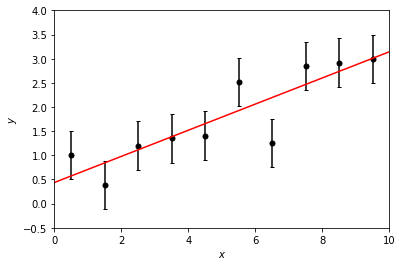

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
%matplotlib inline

# Function which evaluates the chi-squared value of a model y=a*x+b for the (x,y) dataset
def chisqstraightline2(p,x,y,yerr):
  a,b = p[0],p[1]
  return np.sum(((y - (a*x + b))/yerr)**2)

# Read in the example dataset sampled from a straight line
# You will need to change the file path to the location where you've saved the data
data = np.loadtxt('../datasets/straightline.dat')
x,y,yerr = data[:,0],data[:,1],data[:,2]

# Find the best-fitting model parameters by minimising chi-squared (same code as in Class 3)
p0 = [0.2,1.]
result = minimize(chisqstraightline2,p0,args=(x,y,yerr))
a,b = result['x']

# Plot the dataset and best fit
xmin,xmax = 0.,10.
ymin,ymax = -0.5,4.
plt.plot(x,y,marker='o',markersize=5,color='black',linestyle='None')
plt.errorbar(x,y,yerr=yerr,color='black',capsize=2.,linestyle='None')
plt.plot([xmin,xmax],[a*xmin+b,a*xmax+b],color='red')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

We now compute $\chi^2$ over a grid and convert this to a 2D probability distribution:

Text(0, 0.5, '$b$')

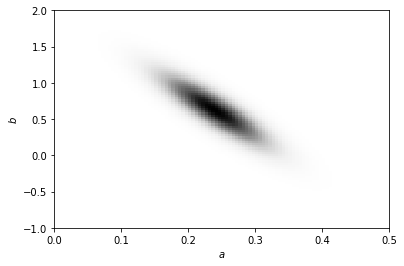

In [2]:
# Determine the chi-squared values over a grid of model parameters a,b
# Set the range of parameters a,b and number of grid points
amin,amax,na = 0.,0.5,100
bmin,bmax,nb = -1.,2.,100
da,db = (amax-amin)/na,(bmax-bmin)/nb
alst = np.linspace(amin+0.5*da,amax-0.5*da,na)
blst = np.linspace(bmin+0.5*db,bmax-0.5*db,nb)
# Evaluate the chi-squared value at each grid point (i.e. for each set of model parameters)
chisq2 = np.empty((na,nb))
for i in range(na):
  for j in range(nb):
    chisq2[i,j] = chisqstraightline2([alst[i],blst[j]],x,y,yerr)
# Find the minimum value of chi-squared across the grid
minchisq = np.amin(chisq2)
# Convert the chi-squared values into a probability, using P \propto exp(-chisq/2)
# We subtract the minimum chi-squared value in the exponent, to avoid numerical issues of exp(-large number)
prob2 = np.exp(-0.5*(chisq2-minchisq))
# Normalise the probability grid such that \sum P(a,b) = 1
prob2 /= np.sum(prob2)
# Plot the probability grid as a greyscale
plt.imshow(prob2,aspect='auto',origin='lower',interpolation='nearest',clim=(0.,np.amax(prob2)),cmap='Greys',extent=[amin,amax,bmin,bmax])
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')

Then we marginalize to obtain the posterior probability distributions for each parameter, $P(a)$ and $P(b)$:

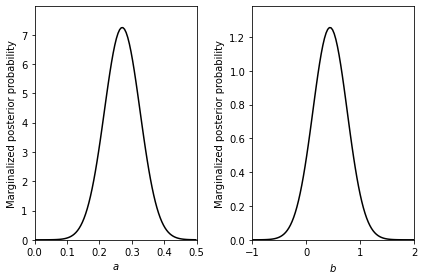

In [3]:
# Marginalise the 2D probability distribution to obtain the 1D posterior probabilities of the 2 parameters
# Marginalise parameter b, by summing over the probabilities corresponding to all values of b
proba = np.sum(prob2,axis=1)
# Marginalise parameter a, by summing over the probabilities corresponding to all values of a
probb = np.sum(prob2,axis=0)
# Normalise the probabilities such that \int P(a) da = 1 (currently, \sum P(a) = 1)
proba /= da
probb /= db
# Plot the posterior probability distributions for a and b
fig = plt.figure()
plt.subplot(121)
ymin,ymax = 0.,1.1*np.amax(proba)
plt.plot(alst,proba,color='black')
plt.xlabel(r'$a$')
plt.ylabel('Marginalized posterior probability')
plt.xlim(amin,amax)
plt.ylim(ymin,ymax)
plt.subplot(122)
ymin,ymax = 0.,1.1*np.amax(probb)
plt.plot(blst,probb,color='black')
plt.xlabel(r'$b$')
plt.ylabel('Marginalized posterior probability')
plt.xlim(bmin,bmax)
plt.ylim(ymin,ymax)
fig.tight_layout()

By integrating under these distributions, we identify the 68% confidence regions:

Lower limit of 68% confidence region for a = 0.21537749641344503
Upper limit of 68% confidence region for a = 0.3254708870429598
Lower limit of 68% confidence region for b = 0.12026579012928584
Upper limit of 68% confidence region for b = 0.7555475906345718


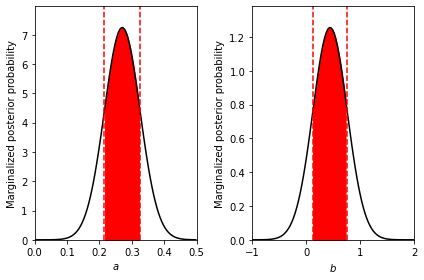

In [4]:
# Function which identifies the parameter values enclosing the central 68.27% of the probability (1-sigma region)
# These values divide the total probability into regions containing ~16%, 68%, 16% 
def geterr(prob,val):
  prob1 = prob/(0.01*np.sum(prob)) # normalise the probability such that it sums to 100
  lik = 31.73 # corresponds to 100 minus the 1-sigma confidence probability
  likby2 = lik/2. # probability enclosed in each of the 2 tails outside the 68% confidence region
  dval = val[1] - val[0]
  cumprob = np.cumsum(prob1) # cumulative probability, ranging from 0 to 100
  botval = np.interp(likby2,cumprob,val) + 0.5*dval # interpolate to determine the lower limit of the 68% region
  topval = np.interp(100.-likby2,cumprob,val) + 0.5*dval # interpolate to determine the upper limit of the 68% region
  return botval,topval

# Determine the lower and upper values of parameter a, enclosing 68% of the posterior probability distribution
abot,atop = geterr(proba,alst)
print('Lower limit of 68% confidence region for a =',abot)
print('Upper limit of 68% confidence region for a =',atop)
# Determine the lower and upper values of parameter b, enclosing 68% of the posterior probability distribution
bbot,btop = geterr(probb,blst)
print('Lower limit of 68% confidence region for b =',bbot)
print('Upper limit of 68% confidence region for b =',btop)

# Plot the probabilty distributions, shading the 68% confidence regions
fig = plt.figure()
plt.subplot(121)
ymin,ymax = 0.,1.1*np.amax(proba)
i1,i2 = int((abot-amin)/da),int((atop-amin)/da) # array indices corresponding to 68% limits
plt.plot(alst,proba,color='black')
plt.plot([abot,abot],[ymin,ymax],color='red',linestyle='dashed')
plt.plot([atop,atop],[ymin,ymax],color='red',linestyle='dashed')
plt.fill_between(alst[i1:i2],np.zeros(i2-i1),proba[i1:i2],color='red')
plt.xlabel(r'$a$')
plt.ylabel('Marginalized posterior probability')
plt.xlim(amin,amax)
plt.ylim(ymin,ymax)
plt.subplot(122)
ymin,ymax = 0.,1.1*np.amax(probb)
i1,i2 = int((bbot-bmin)/db),int((btop-bmin)/db) # array indices corresponding to 68% limits
plt.plot(blst,probb,color='black')
plt.plot([bbot,bbot],[ymin,ymax],color='red',linestyle='dashed')
plt.plot([btop,btop],[ymin,ymax],color='red',linestyle='dashed')
plt.fill_between(blst[i1:i2],np.zeros(i2-i1),probb[i1:i2],color='red')
plt.xlabel(r'$b$')
plt.ylabel('Marginalized posterior probability')
plt.xlim(bmin,bmax)
plt.ylim(ymin,ymax)
fig.tight_layout()

## Activity

Let's return to the same supernova distance-redshift dataset we were using in Class 3.

- Convert the $\chi^2$ values into a **joint 2D probability distribution** in $(\Omega_m,\Omega_\Lambda)$
- Marginalize this probability distribution to obtain the **1D posterior probability distributions** for $\Omega_m$ and $\Omega_\Lambda$
- Determine the **68% confidence regions** for $\Omega_m$ and $\Omega_\Lambda$

## Monte Carlo Markov Chains

The grid method becomes inefficient as the number of parameters increases.  A powerful alternative is to generate a **Monte Carlo Markov Chain** (MCMC) in the parameter space.

The end result is a "chain" (distribution of parameter values) which **samples the underlying probability distribution**.

Here is a worked example of using python's emcee algorithm to sample the probability distribution of the straight-line fit:

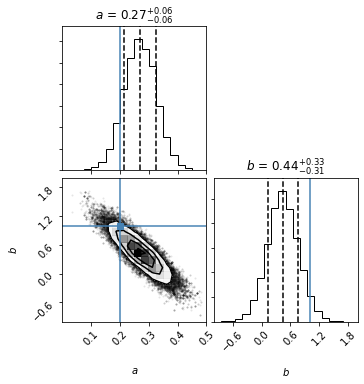

In [5]:
import emcee
import corner

# Uniform prior
def lnpriorline(p,amin,amax,bmin,bmax):
  a,b = p
  if ((amin < a < amax) and (bmin < b < bmax)):
    return 0.0
  return -np.inf

# Likelihood
def lnlikeline(p,x,y,yerr):
  chisq = chisqstraightline2(p,x,y,yerr)
  return -0.5*chisq

# Posterior
def lnprobline(p,x,y,yerr,amin,amax,bmin,bmax):
  lp = lnpriorline(p,amin,amax,bmin,bmax)
  if not np.isfinite(lp):
    return -np.inf
  return lp + lnlikeline(p,x,y,yerr)

ndim = 2 # Number of parameters
nwalkers = 100 # Number of walkers
a0,b0 = 0.2,1. # Fiducial values
# Priors
amin,amax = 0.,0.5
bmin,bmax = -1.,2.
# Initialize the chain
pmin = np.array([amin,bmin])
pmax = np.array([amax,bmax])
p = [pmin + (pmax-pmin)*np.random.rand(ndim) for i in range(nwalkers)]
# Set up sampler
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprobline,args=(x,y,yerr,amin,amax,bmin,bmax))
# Burn-in phase (use 300 steps)
p,prob,state = sampler.run_mcmc(p,300)
sampler.reset()
# Perform MCMC (use 700 steps)
p,prob,state = sampler.run_mcmc(p,700)
samples = sampler.flatchain
achain,bchain = samples[:,0],samples[:,1]
# Plot the chains
fig = corner.corner(samples, labels=["$a$", "$b$"], range=[[amin,amax], [bmin,bmax]], truths=[a0,b0], quantiles=[0.16, 0.5, 0.84], show_titles=True, labels_args={"fontsize": 40})
plt.show()

## Activity

For the supernova distance-redshift dataset:

- Run an **MCMC analysis** for parameters $(\Omega_m,\Omega_\Lambda)$
- Determine the **68% confidence regions** of $\Omega_m$ and $\Omega_\Lambda$

## Model selection

Since Bayesian statistics is related to the probability of models, it allows us to perform **model selection**.

A typical example is how many model parameters does a dataset justify including in a fit.

A common approach to this problem is to calculate the **Akaike information criteria** for each model:

$AIC = \chi_{\rm min}^2 + 2p + \frac{2p(p+1)}{N - p - 1}$

where $p$ is the number of model parameters, and $N$ is the number of data bins.  This formulation penalizes models with more parameters.

## Activity

Returning to the same supernova distance-redshift dataset, compute the **Akaike information criteria** for a flat model (where $\Omega_m + \Omega_\Lambda = 1$) and a **curved model** (where $\Omega_m$ and $\Omega_\Lambda$ can take any value).  Which model is preferred by this metric?